# Biol 359A | Regularization
### Spring 2025, Week 4
Objectives:
- Understand the Bias-Variance Tradeoff: Learn how increasing model complexity impacts bias and variance.
- Gain intuition for Regularization Techniques: Implement Ridge and LASSO to prevent overfitting.
- Implement Model Evaluation and Selection: Employ train-test splits for optimal model selection.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, differential_evolution
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.integrate import odeint
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

The Lotka–Volterra model is a set of coupled differential equations that describe the dynamics of two species interact as predator and prey. The dynamics is characterized by oscillatory population cycles, where prey growth drives predator population increase, and increased predation subsequently reduces prey.

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y \\
\frac{dy}{dt} &= \delta x y - \gamma y
\end{align}

\begin{aligned}
x &: \text{prey population} \\
y &: \text{predator population} \\
\alpha &: \text{prey growth rate (in absence of predators)} \\
\beta &: \text{predation rate coefficient} \\
\delta &: \text{conversion efficiency of prey into predator growth} \\
\gamma &: \text{predator death rate (in absence of prey)}
\end{aligned}

Where $\boldsymbol{\theta} = (\alpha, \gamma)$ are parameters to estimate, $\beta = 0.1, \delta = 0.075$ are fixed.

In [2]:
def lotka_volterra(z, t, alpha, beta, delta, gamma):
    """Lotka-Volterra differential equations"""
    x, y = z
    dx_dt = alpha * x - beta * x * y
    dy_dt = delta * x * y - gamma * y
    return [dx_dt, dy_dt]

def simulate_lotka_volterra(params, time_points, initial_conditions,
                           beta=0.1, delta=0.075, add_noise=True, noise_level=0.05):
    """
    Simulate Lotka-Volterra model

    Parameters:
    -----------
    params : tuple
        (alpha, gamma) - parameters to estimate
    time_points : array
        Time points for simulation
    initial_conditions : tuple
        (initial_prey, initial_predator)
    add_noise : bool
        Whether to add observation noise

    Returns:
    --------
    result : array
        Simulated populations [prey, predator] over time
    """
    alpha, gamma = params

    try:
        result = odeint(lotka_volterra, initial_conditions, time_points,
                       args=(alpha, beta, delta, gamma))

        if add_noise:
            noise = np.random.normal(0, noise_level, result.shape) * result
            result = result + noise
            # Ensure populations stay positive
            result = np.maximum(result, 0.01)

        return result
    except:
        # Return large values if integration fails
        return np.ones((len(time_points), 2)) * 1e6

## Generate observed data

In [3]:
def generate_observed_data(true_alpha=1.0, true_gamma=1.0, noise_level=0.05, time_points=31):
    """Generate observed data with controllable parameters"""
    time_array = np.linspace(0, 30, time_points)
    initial_conditions = (10, 5)

    observed_data = simulate_lotka_volterra(
        (true_alpha, true_gamma),
        time_array,
        initial_conditions,
        add_noise=True,
        noise_level=noise_level
    )

    return {
        'data': observed_data,
        'time': time_array,
        'initial': initial_conditions,
        'true_params': (true_alpha, true_gamma)
    }


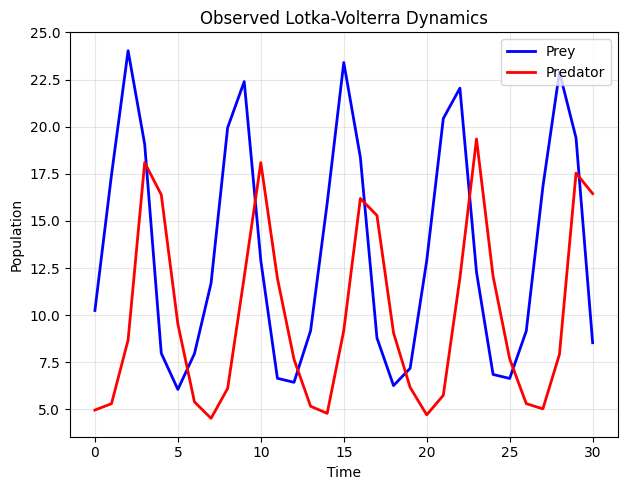

✓ Data generated with 31 time points
✓ True parameters: α = 1.0, γ = 1.0
✓ Initial conditions: Prey = 10, Predator = 5


In [4]:
obs_data = generate_observed_data()
# Plot the observed data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(obs_data['time'], obs_data['data'][:, 0], 'b-', linewidth=2, label='Prey')
plt.plot(obs_data['time'], obs_data['data'][:, 1], 'r-', linewidth=2, label='Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Observed Lotka-Volterra Dynamics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Data generated with {len(obs_data['time'])} time points")
print(f"✓ True parameters: α = {obs_data['true_params'][0]}, γ = {obs_data['true_params'][1]}")
print(f"✓ Initial conditions: Prey = {obs_data['initial'][0]}, Predator = {obs_data['initial'][1]}")

## Method 1: Least squares estimation

LS finds parameters that minimize the sum of squared differences (S) between observed and simulated data. (optimization problem)

- Objective function: minimize Σ(observed - simulated)²
- Uses optimization algorithms (L-BFGS-B, differential evolution)


\begin{align}
\hat{\boldsymbol{\theta}}_{\mathrm{LS}}
&= \arg\min_{\boldsymbol{\theta}} S(\boldsymbol{\theta}) \\[6pt]
S(\boldsymbol{\theta})
&= \sum_{i=1}^{n} \left[
(x_i - \hat{x}_i(\boldsymbol{\theta}))^2 +
(y_i - \hat{y}_i(\boldsymbol{\theta}))^2
\right] \\[6pt]
\end{align}



In [5]:
def estimate_least_squares(observed_data, time_points, initial_conditions,
                          starting_points=[(0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0)]):
    """Least squares estimation with controllable starting points"""
    def objective(params):
        try:
            simulated = simulate_lotka_volterra(params, time_points, initial_conditions, add_noise=False)
            return np.sum((observed_data - simulated)**2)
        except:
            return 1e10

    best_result = None
    best_score = np.inf

    for start in starting_points:
        try:
            result = minimize(objective, start, bounds=[(0.1, 3.0), (0.1, 3.0)], method='L-BFGS-B')
            if result.success and result.fun < best_score:
                best_result = result
                best_score = result.fun
        except:
            continue

    if best_result is None:
        result = differential_evolution(objective, [(0.1, 3.0), (0.1, 3.0)], seed=42)
        best_result = result

    estimated_params = best_result.x
    simulated = simulate_lotka_volterra(estimated_params, time_points, initial_conditions, add_noise=False)

    return {
        'method': 'Least Squares',
        'params': estimated_params,
        'alpha': estimated_params[0],
        'gamma': estimated_params[1],
        'alpha_std': 0.1,  # Approximation
        'gamma_std': 0.1,
        'simulated_data': simulated
    }

📈 LEAST SQUARES ESTIMATION
Parameter Estimates:
  α (prey growth):     0.9964 ± 0.1000
  γ (predator death):  1.0046 ± 0.1000

Estimation Errors:
  α error: 0.0036
  γ error: 0.0046


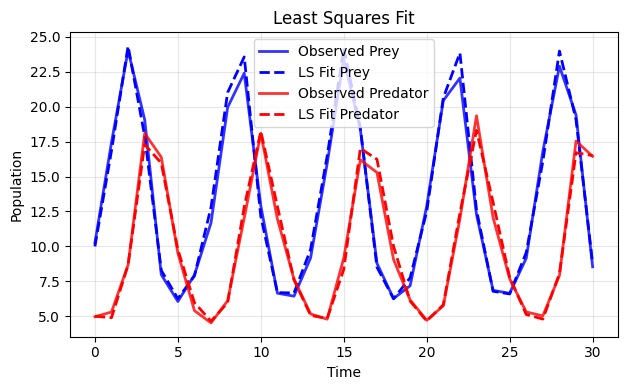

In [6]:
print("📈 LEAST SQUARES ESTIMATION")
print("=" * 40)
ls_result = estimate_least_squares(
    obs_data['data'],
    obs_data['time'],
    obs_data['initial']
)
true_params = obs_data['true_params']
print("Parameter Estimates:")
print(f"  α (prey growth):     {ls_result['alpha']:.4f} ± {ls_result['alpha_std']:.4f}")
print(f"  γ (predator death):  {ls_result['gamma']:.4f} ± {ls_result['gamma_std']:.4f}")
print()
print("Estimation Errors:")
print(f"  α error: {abs(ls_result['alpha'] - true_params[0]):.4f}")
print(f"  γ error: {abs(ls_result['gamma'] - true_params[1]):.4f}")

# Plot comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(obs_data['time'], obs_data['data'][:, 0], 'b-', linewidth=2, label='Observed Prey', alpha=0.8)
plt.plot(obs_data['time'], ls_result['simulated_data'][:, 0], 'b--', linewidth=2, label='LS Fit Prey')
plt.plot(obs_data['time'], obs_data['data'][:, 1], 'r-', linewidth=2, label='Observed Predator', alpha=0.8)
plt.plot(obs_data['time'], ls_result['simulated_data'][:, 1], 'r--', linewidth=2, label='LS Fit Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Least Squares Fit')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Method 2: Maximum likelihood estimation

- Objective: Maximize the likelihood under Gaussian noise
\begin{align}
\hat{\boldsymbol{\theta}}_{\mathrm{MLE}}
&= \arg\max_{\boldsymbol{\theta}} \, \ell(\boldsymbol{\theta})
\end{align}

- Likelihood:
\begin{align}
L(\boldsymbol{\theta})
&= \prod_{i=1}^{n} \frac{1}{\sqrt{2 \pi \sigma^2}}
\exp\left( - \frac{(y_i - f(\boldsymbol{\theta}, t_i))^2}{2 \sigma^2} \right) \\
&= \left( \frac{1}{\sqrt{2 \pi \sigma^2}} \right)^n
\exp\left( - \frac{1}{2 \sigma^2} \sum_{i=1}^{n} (y_i - f(\boldsymbol{\theta}, t_i))^2 \right)
\end{align}

- Log-likelihood for Gaussian errors:
\begin{align}
\ell(\boldsymbol{\theta})
&= - \frac{1}{2\sigma^2} \sum_{i=1}^{n}
     \left\lVert \mathbf{y}_i - \mathbf{f}(\boldsymbol{\theta}, t_i) \right\rVert^2
   - \frac{n}{2} \log (2\pi \sigma^2)
\end{align}


- Noise term:
\begin{align}
\sigma^2 &= (\text{noise level})^2 \cdot \overline{(y^{\text{obs}})^2}
\end{align}


In [7]:
def log_likelihood(params, observed_data, time_points, initial_conditions, noise_level=0.05):
    """Log-likelihood function assuming Gaussian noise"""
    try:
        simulated = simulate_lotka_volterra(params, time_points, initial_conditions, add_noise=False)

        # Gaussian likelihood
        residuals = observed_data - simulated
        log_lik = -0.5 * np.sum(residuals**2) / (noise_level**2 * np.mean(observed_data**2))
        log_lik -= len(residuals.flatten()) * np.log(noise_level * np.sqrt(np.mean(observed_data**2))) # ignore constant term

        return log_lik
    except:
        return -1e10

def estimate_mle(observed_data, time_points, initial_conditions,
                starting_points=[(0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0)]):
    """MLE estimation with controllable starting points"""
    def neg_log_likelihood(params):
        return -log_likelihood(params, observed_data, time_points, initial_conditions)

    best_result = None
    best_score = np.inf

    for start in starting_points:
        try:
            result = minimize(neg_log_likelihood, start, bounds=[(0.1, 3.0), (0.1, 3.0)], method='L-BFGS-B')
            if result.success and result.fun < best_score:
                best_result = result
                best_score = result.fun
        except:
            continue

    if best_result is None:
        result = differential_evolution(neg_log_likelihood, [(0.1, 3.0), (0.1, 3.0)], seed=42)
        best_result = result

    estimated_params = best_result.x
    simulated = simulate_lotka_volterra(estimated_params, time_points, initial_conditions, add_noise=False)

    return {
        'method': 'Maximum Likelihood',
        'params': estimated_params,
        'alpha': estimated_params[0],
        'gamma': estimated_params[1],
        'alpha_std': 0.1,
        'gamma_std': 0.1,
        'log_likelihood': -best_result.fun,
        'simulated_data': simulated
    }


📊 MAXIMUM LIKELIHOOD ESTIMATION
Log-likelihood: -0.806600

Parameter Estimates:
  α (prey growth):     1.0000 ± 0.1000
  γ (predator death):  1.0000 ± 0.1000

Estimation Errors:
  α error: 0.0000
  γ error: 0.0000


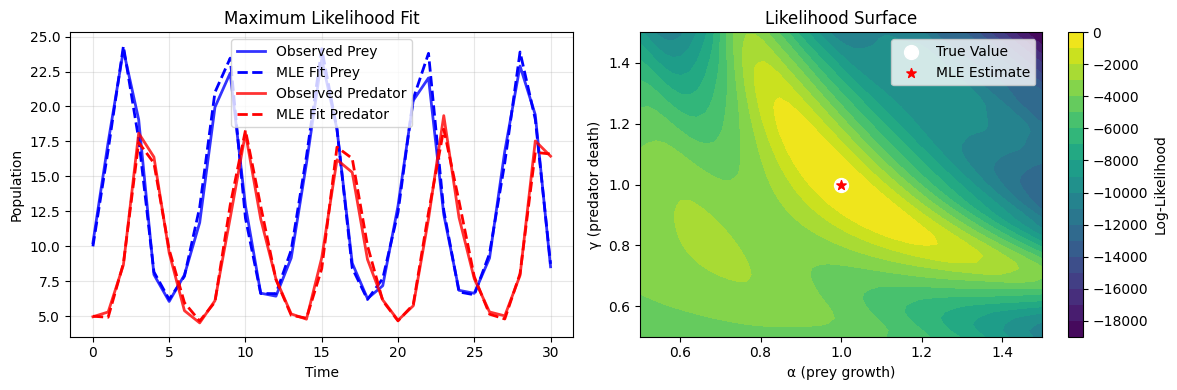

In [8]:
"""Cell 3: Maximum Likelihood Estimation"""
print("📊 MAXIMUM LIKELIHOOD ESTIMATION")
print("=" * 40)

mle_result = estimate_mle(
    obs_data['data'],
    obs_data['time'],
    obs_data['initial']
)
true_params = obs_data['true_params']

print(f"Log-likelihood: {mle_result['log_likelihood']:.6f}")
print()
print("Parameter Estimates:")
print(f"  α (prey growth):     {mle_result['alpha']:.4f} ± {mle_result['alpha_std']:.4f}")
print(f"  γ (predator death):  {mle_result['gamma']:.4f} ± {mle_result['gamma_std']:.4f}")
print()
print("Estimation Errors:")
print(f"  α error: {abs(mle_result['alpha'] - true_params[0]):.4f}")
print(f"  γ error: {abs(mle_result['gamma'] - true_params[1]):.4f}")

# Plot comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(obs_data['time'], obs_data['data'][:, 0], 'b-', linewidth=2, label='Observed Prey', alpha=0.8)
plt.plot(obs_data['time'], mle_result['simulated_data'][:, 0], 'b--', linewidth=2, label='MLE Fit Prey')
plt.plot(obs_data['time'], obs_data['data'][:, 1], 'r-', linewidth=2, label='Observed Predator', alpha=0.8)
plt.plot(obs_data['time'], mle_result['simulated_data'][:, 1], 'r--', linewidth=2, label='MLE Fit Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Maximum Likelihood Fit')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Likelihood surface (simplified 2D slice)
alpha_range = np.linspace(0.5, 1.5, 50)
gamma_range = np.linspace(0.5, 1.5, 50)
A, G = np.meshgrid(alpha_range, gamma_range)

likelihood_surface = np.zeros_like(A)
for i in range(len(alpha_range)):
    for j in range(len(gamma_range)):
        likelihood_surface[j, i] = log_likelihood(
            (alpha_range[i], gamma_range[j]),
            obs_data['data'],
            obs_data['time'],
            obs_data['initial']
        )

plt.contourf(A, G, likelihood_surface, levels=20, cmap='viridis')
plt.colorbar(label='Log-Likelihood')
plt.scatter(true_params[0], true_params[1], color='white', s=100, marker='o', label='True Value')
plt.scatter(mle_result['alpha'], mle_result['gamma'], color='red', s=50, marker='*', label='MLE Estimate')

plt.xlabel('α (prey growth)')
plt.ylabel('γ (predator death)')
plt.title('Likelihood Surface')
plt.legend()

plt.tight_layout()
plt.show()

## Method 3: Bayesian estimation

**Objective:** Sample from the posterior distribution:

$$
p(\boldsymbol{\theta} \mid \mathbf{y}_{\mathrm{obs}}) \propto p(\mathbf{y}_{\mathrm{obs}} \mid \boldsymbol{\theta}) \, p(\boldsymbol{\theta})
$$

**Metropolis-Hastings Algorithm**

1. Propose:

$$
\boldsymbol{\theta}^* \sim q(\boldsymbol{\theta}^* \mid \boldsymbol{\theta}^{t-1})
$$

2. Accept with probability:

$$
\alpha = \min\left(1, \frac{p(\boldsymbol{\theta}^* \mid \mathbf{y}_{\mathrm{obs}}) \, q(\boldsymbol{\theta}^{t-1} \mid \boldsymbol{\theta}^*)}{p(\boldsymbol{\theta}^{t-1} \mid \mathbf{y}_{\mathrm{obs}}) \, q(\boldsymbol{\theta}^* \mid \boldsymbol{\theta}^{t-1})}\right)
$$

2b. For symmetric proposals:

$$
\alpha = \min\left(1, \frac{p(\boldsymbol{\theta}^* \mid \mathbf{y}_{\mathrm{obs}})}{p(\boldsymbol{\theta}^{t-1} \mid \mathbf{y}_{\mathrm{obs}})}\right)
$$

3. **Posterior summary:**

$$
\hat{\boldsymbol{\theta}}_{\mathrm{Bayes}} = \mathbb{E}[\boldsymbol{\theta} \mid \mathbf{y}_{\mathrm{obs}}] \approx \frac{1}{T} \sum_{t=1}^T \boldsymbol{\theta}^t
$$


In [9]:
def metropolis_hastings(observed_data, time_points, initial_conditions,
                       n_samples=2000, burn_in=500, proposal_std=0.05,
                       current_params=(1.0, 1.0)):
    """MCMC with controllable parameters"""
    def log_likelihood(params):
        try:
            simulated = simulate_lotka_volterra(params, time_points, initial_conditions, add_noise=False)
            residuals = observed_data - simulated
            return -0.5 * np.sum(residuals**2) / (0.05**2 * np.mean(observed_data**2))
        except:
            return -1e10

    def log_prior(params):
        alpha, gamma = params
        if 0.1 <= alpha <= 3.0 and 0.1 <= gamma <= 3.0:
            return 0.0
        return -np.inf

    def log_posterior(params):
        lp = log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(params)

    current = np.array(current_params)
    samples = []
    accepted = 0

    current_log_post = log_posterior(current)

    for i in range(n_samples + burn_in):
        proposal = current + np.random.normal(0, proposal_std, 2)
        proposal_log_post = log_posterior(proposal)

        if np.isfinite(proposal_log_post):
            alpha = min(1, np.exp(proposal_log_post - current_log_post))
            if np.random.random() < alpha:
                current = proposal
                current_log_post = proposal_log_post
                accepted += 1

        if i >= burn_in:
            samples.append(current.copy())

    samples = np.array(samples)
    alpha_mean = np.mean(samples[:, 0])
    gamma_mean = np.mean(samples[:, 1])
    alpha_std = np.std(samples[:, 0])
    gamma_std = np.std(samples[:, 1])

    simulated = simulate_lotka_volterra((alpha_mean, gamma_mean), time_points, initial_conditions, add_noise=False)

    return {
        'method': 'Bayesian (MCMC)',
        'params': (alpha_mean, gamma_mean),
        'alpha': alpha_mean,
        'gamma': gamma_mean,
        'alpha_std': alpha_std,
        'gamma_std': gamma_std,
        'samples': samples,
        'acceptance_rate': accepted / (n_samples + burn_in),
        'simulated_data': simulated
    }

🎲 BAYESIAN MCMC ESTIMATION
MCMC completed with 5000 samples
Acceptance rate: 0.75%

Parameter Estimates (Posterior Mean):
  α (prey growth):     0.9959 ± 0.0042
  γ (predator death):  1.0051 ± 0.0053

Estimation Errors:
  α error: 0.0041
  γ error: 0.0051

Credible Intervals (95%):
  α: [0.9867, 1.0034]
  γ: [0.9960, 1.0150]


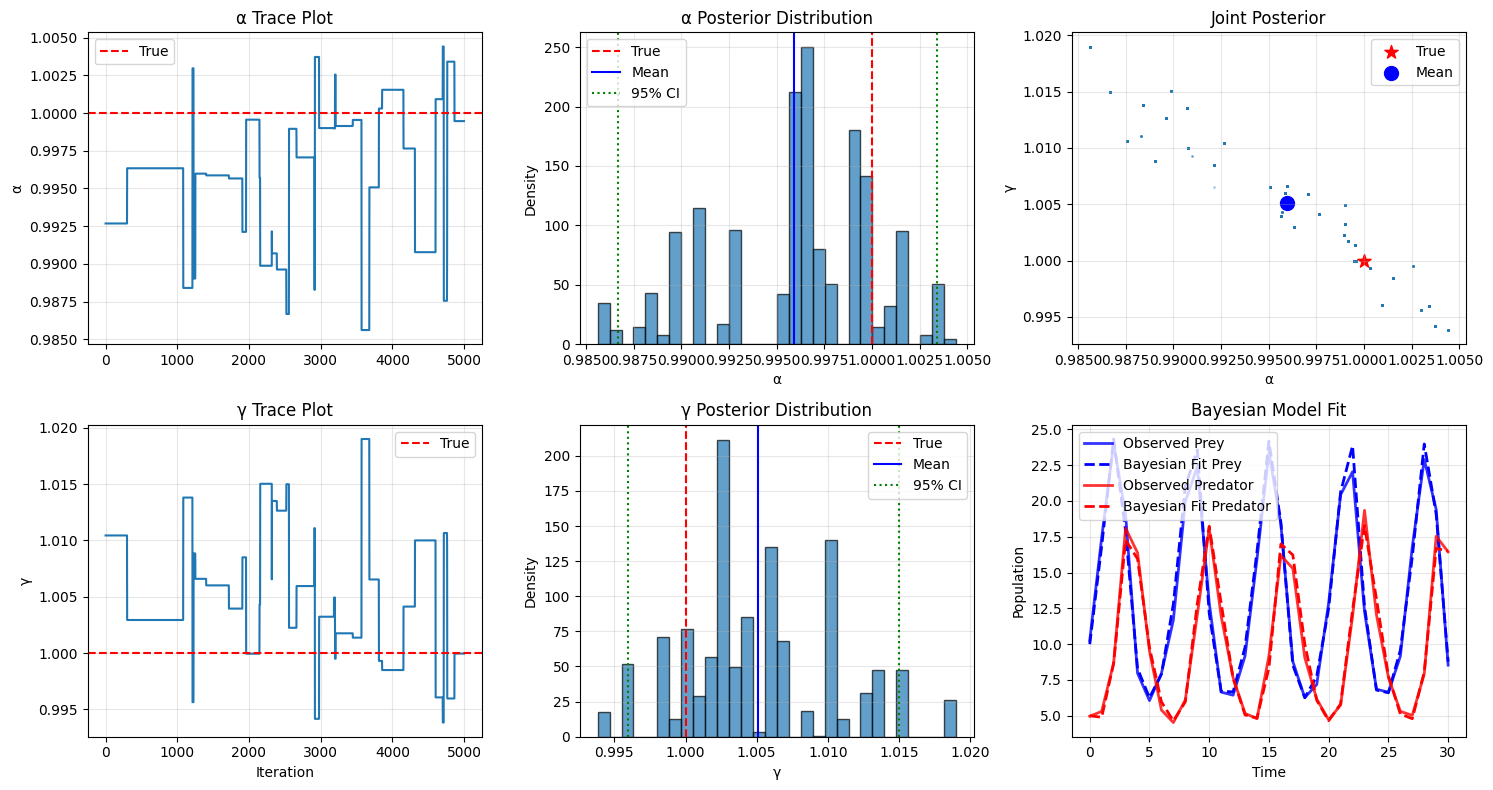

In [10]:
print("🎲 BAYESIAN MCMC ESTIMATION")
print("=" * 40)

mcmc_result = metropolis_hastings(
    obs_data['data'],
    obs_data['time'],
    obs_data['initial'],
    n_samples=5000,
    burn_in=1000
)

true_params = obs_data['true_params']
samples = mcmc_result['samples']

print(f"MCMC completed with {len(samples)} samples")
print(f"Acceptance rate: {mcmc_result['acceptance_rate']:.2%}")
print()
print("Parameter Estimates (Posterior Mean):")
print(f"  α (prey growth):     {mcmc_result['alpha']:.4f} ± {mcmc_result['alpha_std']:.4f}")
print(f"  γ (predator death):  {mcmc_result['gamma']:.4f} ± {mcmc_result['gamma_std']:.4f}")
print()
print("Estimation Errors:")
print(f"  α error: {abs(mcmc_result['alpha'] - true_params[0]):.4f}")
print(f"  γ error: {abs(mcmc_result['gamma'] - true_params[1]):.4f}")
print()
print("Credible Intervals (95%):")
alpha_ci = np.percentile(samples[:, 0], [2.5, 97.5])
gamma_ci = np.percentile(samples[:, 1], [2.5, 97.5])
print(f"  α: [{alpha_ci[0]:.4f}, {alpha_ci[1]:.4f}]")
print(f"  γ: [{gamma_ci[0]:.4f}, {gamma_ci[1]:.4f}]")

# Plot MCMC diagnostics and results
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Trace plots
axes[0, 0].plot(samples[:, 0])
axes[0, 0].axhline(true_params[0], color='red', linestyle='--', label='True')
axes[0, 0].set_title('α Trace Plot')
axes[0, 0].set_ylabel('α')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[1, 0].plot(samples[:, 1])
axes[1, 0].axhline(true_params[1], color='red', linestyle='--', label='True')
axes[1, 0].set_title('γ Trace Plot')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('γ')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Posterior distributions
axes[0, 1].hist(samples[:, 0], bins=30, alpha=0.7, density=True, edgecolor='black')
axes[0, 1].axvline(true_params[0], color='red', linestyle='--', label='True')
axes[0, 1].axvline(mcmc_result['alpha'], color='blue', linestyle='-', label='Mean')
axes[0, 1].axvline(alpha_ci[0], color='green', linestyle=':', label='95% CI')
axes[0, 1].axvline(alpha_ci[1], color='green', linestyle=':')
axes[0, 1].set_title('α Posterior Distribution')
axes[0, 1].set_xlabel('α')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 1].hist(samples[:, 1], bins=30, alpha=0.7, density=True, edgecolor='black')
axes[1, 1].axvline(true_params[1], color='red', linestyle='--', label='True')
axes[1, 1].axvline(mcmc_result['gamma'], color='blue', linestyle='-', label='Mean')
axes[1, 1].axvline(gamma_ci[0], color='green', linestyle=':', label='95% CI')
axes[1, 1].axvline(gamma_ci[1], color='green', linestyle=':')
axes[1, 1].set_title('γ Posterior Distribution')
axes[1, 1].set_xlabel('γ')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Joint posterior
axes[0, 2].scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=1)
axes[0, 2].scatter(true_params[0], true_params[1], color='red', s=100, marker='*', label='True')
axes[0, 2].scatter(mcmc_result['alpha'], mcmc_result['gamma'], color='blue', s=100, marker='o', label='Mean')
axes[0, 2].set_title('Joint Posterior')
axes[0, 2].set_xlabel('α')
axes[0, 2].set_ylabel('γ')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Model fit
axes[1, 2].plot(obs_data['time'], obs_data['data'][:, 0], 'b-', linewidth=2, label='Observed Prey', alpha=0.8)
axes[1, 2].plot(obs_data['time'], mcmc_result['simulated_data'][:, 0], 'b--', linewidth=2, label='Bayesian Fit Prey')
axes[1, 2].plot(obs_data['time'], obs_data['data'][:, 1], 'r-', linewidth=2, label='Observed Predator', alpha=0.8)
axes[1, 2].plot(obs_data['time'], mcmc_result['simulated_data'][:, 1], 'r--', linewidth=2, label='Bayesian Fit Predator')
axes[1, 2].set_title('Bayesian Model Fit')
axes[1, 2].set_xlabel('Time')
axes[1, 2].set_ylabel('Population')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ABC

**Objective:** Likelihood-free inference via simulation

$$
p_{ABC}(\boldsymbol{\theta} \mid \mathbf{y}_{\mathrm{obs}})
\propto p(\boldsymbol{\theta})
\int p(\mathbf{y} \mid \boldsymbol{\theta})
\mathbb{I}\big[\rho(\mathbf{S}(\mathbf{y}), \mathbf{S}(\mathbf{y}_{\mathrm{obs}})) \leq \varepsilon\big]
\, d\mathbf{y}
$$

**ABC Algorithm:**

1. Sample $\boldsymbol{\theta}_i \sim p(\boldsymbol{\theta})$ (prior)  
2. Simulate $\mathbf{y}_{\mathrm{sim}} \sim p(\mathbf{y} \mid \boldsymbol{\theta}_i)$  
3. Compute distance  
   $d = \rho(\mathbf{S}(\mathbf{y}_{\mathrm{sim}}), \mathbf{S}(\mathbf{y}_{\mathrm{obs}}))$
4. Accept if $d \leq \varepsilon$

**Distance function:**

$$
\rho(\mathbf{s}_1, \mathbf{s}_2) = \|\mathbf{s}_1 - \mathbf{s}_2\|_2
$$

In [11]:
def compute_summary_stats(data):
    """Compute summary statistics for ABC"""
    prey, predator = data[:, 0], data[:, 1]
    stats = np.array([
        np.mean(prey), np.std(prey), np.max(prey), np.min(prey),
        np.mean(predator), np.std(predator), np.max(predator), np.min(predator),
        np.corrcoef(prey, predator)[0, 1] if len(prey) > 1 else 0
    ])
    return stats

def abc_distance(stats1, stats2):
    """Distance function for ABC"""
    return np.sqrt(np.sum((stats1 - stats2)**2))

def estimate_abc(observed_data, time_points, initial_conditions,
                n_samples=1000, tolerance=None):
    """ABC estimation with controllable parameters"""
    observed_stats = compute_summary_stats(observed_data)

    if tolerance is None or tolerance == 0:
        distances = []
        for _ in range(500):
            alpha = np.random.uniform(0.1, 3.0)
            gamma = np.random.uniform(0.1, 3.0)
            try:
                sim_data = simulate_lotka_volterra((alpha, gamma), time_points, initial_conditions, add_noise=False)
                sim_stats = compute_summary_stats(sim_data)
                distances.append(abc_distance(observed_stats, sim_stats))
            except:
                distances.append(1000)
        tolerance = np.percentile(distances, 10)

    accepted_params = []
    accepted_distances = []
    attempts = 0

    while len(accepted_params) < n_samples and attempts < n_samples * 5:
        alpha = np.random.uniform(0.1, 3.0)
        gamma = np.random.uniform(0.1, 3.0)

        try:
            sim_data = simulate_lotka_volterra((alpha, gamma), time_points, initial_conditions, add_noise=False)
            sim_stats = compute_summary_stats(sim_data)
            distance = abc_distance(observed_stats, sim_stats)

            if distance <= tolerance:
                accepted_params.append([alpha, gamma])
                accepted_distances.append(distance)
        except:
            pass

        attempts += 1

    if len(accepted_params) == 0:
        # Fallback
        temp_params = []
        temp_distances = []
        for _ in range(n_samples):
            alpha = np.random.uniform(0.1, 3.0)
            gamma = np.random.uniform(0.1, 3.0)
            try:
                sim_data = simulate_lotka_volterra((alpha, gamma), time_points, initial_conditions, add_noise=False)
                sim_stats = compute_summary_stats(sim_data)
                distance = abc_distance(observed_stats, sim_stats)
                temp_params.append([alpha, gamma])
                temp_distances.append(distance)
            except:
                temp_params.append([1.0, 1.0])
                temp_distances.append(1000)

        sorted_indices = np.argsort(temp_distances)
        keep_indices = sorted_indices[:max(1, len(temp_params)//10)]
        accepted_params = [temp_params[i] for i in keep_indices]
        accepted_distances = [temp_distances[i] for i in keep_indices]

    accepted_params = np.array(accepted_params)
    alpha_mean = np.mean(accepted_params[:, 0])
    gamma_mean = np.mean(accepted_params[:, 1])
    alpha_std = np.std(accepted_params[:, 0])
    gamma_std = np.std(accepted_params[:, 1])

    simulated = simulate_lotka_volterra((alpha_mean, gamma_mean), time_points, initial_conditions, add_noise=False)

    return {
        'method': 'ABC',
        'params': (alpha_mean, gamma_mean),
        'alpha': alpha_mean,
        'gamma': gamma_mean,
        'alpha_std': alpha_std,
        'gamma_std': gamma_std,
        'samples': accepted_params,
        'distances': accepted_distances,
        'tolerance': tolerance,
        'acceptance_rate': len(accepted_params) / attempts,
        'simulated_data': simulated
    }

🎯 APPROXIMATE BAYESIAN COMPUTATION (ABC)
ABC completed with 1350 accepted samples
Acceptance rate: 13.50%
Distance tolerance: 16.995487

Parameter Estimates (ABC Posterior):
  α (prey growth):     0.9150 ± 0.3051
  γ (predator death):  0.9302 ± 0.3416

Estimation Errors:
  α error: 0.0850
  γ error: 0.0698


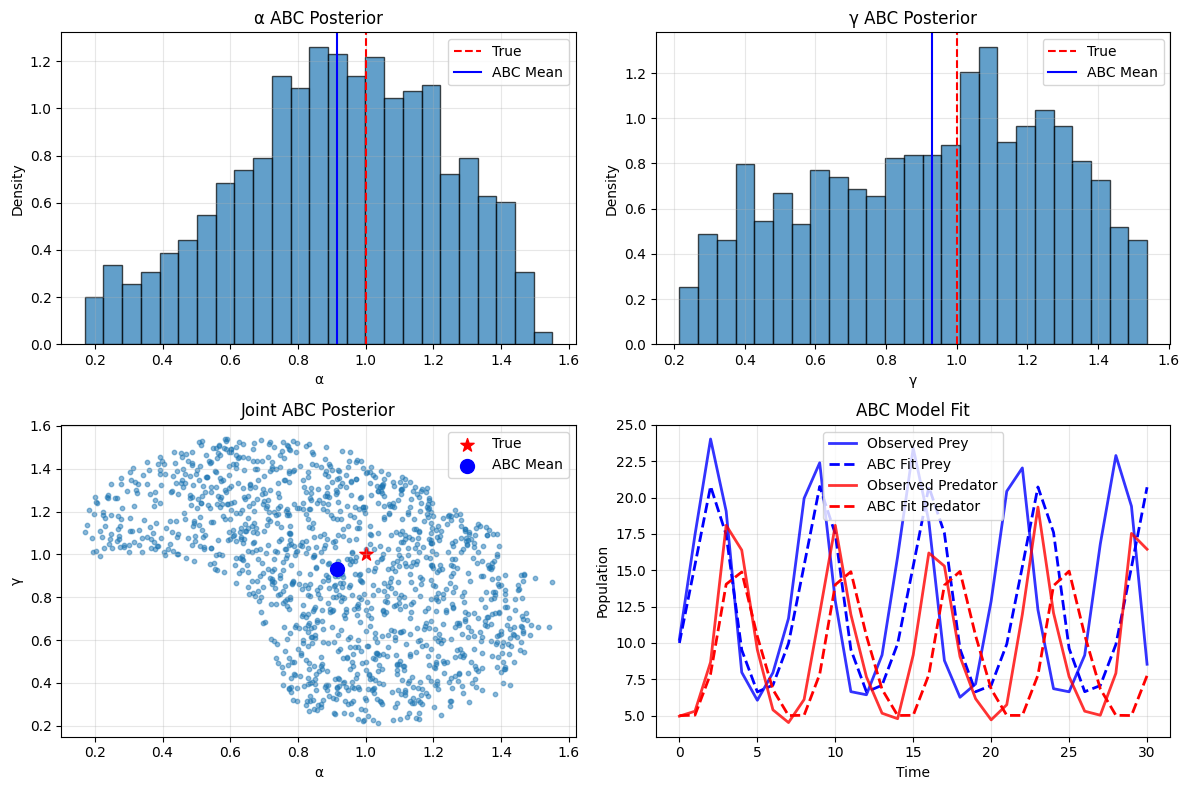

In [12]:
"""Cell 5: ABC Estimation"""
print("🎯 APPROXIMATE BAYESIAN COMPUTATION (ABC)")
print("=" * 40)

abc_result = estimate_abc(
    obs_data['data'],
    obs_data['time'],
    obs_data['initial'],
    n_samples=2000
)

true_params = obs_data['true_params']
samples = abc_result['samples']

print(f"ABC completed with {len(samples)} accepted samples")
print(f"Acceptance rate: {abc_result['acceptance_rate']:.2%}")
print(f"Distance tolerance: {abc_result['tolerance']:.6f}")
print()
print("Parameter Estimates (ABC Posterior):")
print(f"  α (prey growth):     {abc_result['alpha']:.4f} ± {abc_result['alpha_std']:.4f}")
print(f"  γ (predator death):  {abc_result['gamma']:.4f} ± {abc_result['gamma_std']:.4f}")
print()
print("Estimation Errors:")
print(f"  α error: {abs(abc_result['alpha'] - true_params[0]):.4f}")
print(f"  γ error: {abs(abc_result['gamma'] - true_params[1]):.4f}")

# Plot ABC results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ABC posterior distributions
axes[0, 0].hist(samples[:, 0], bins=25, alpha=0.7, density=True, edgecolor='black')
axes[0, 0].axvline(true_params[0], color='red', linestyle='--', label='True')
axes[0, 0].axvline(abc_result['alpha'], color='blue', linestyle='-', label='ABC Mean')
axes[0, 0].set_title('α ABC Posterior')
axes[0, 0].set_xlabel('α')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(samples[:, 1], bins=25, alpha=0.7, density=True, edgecolor='black')
axes[0, 1].axvline(true_params[1], color='red', linestyle='--', label='True')
axes[0, 1].axvline(abc_result['gamma'], color='blue', linestyle='-', label='ABC Mean')
axes[0, 1].set_title('γ ABC Posterior')
axes[0, 1].set_xlabel('γ')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Joint ABC posterior
axes[1, 0].scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10)
axes[1, 0].scatter(true_params[0], true_params[1], color='red', s=100, marker='*', label='True')
axes[1, 0].scatter(abc_result['alpha'], abc_result['gamma'], color='blue', s=100, marker='o', label='ABC Mean')
axes[1, 0].set_title('Joint ABC Posterior')
axes[1, 0].set_xlabel('α')
axes[1, 0].set_ylabel('γ')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Model fit
axes[1, 1].plot(obs_data['time'], obs_data['data'][:, 0], 'b-', linewidth=2, label='Observed Prey', alpha=0.8)
axes[1, 1].plot(obs_data['time'], abc_result['simulated_data'][:, 0], 'b--', linewidth=2, label='ABC Fit Prey')
axes[1, 1].plot(obs_data['time'], obs_data['data'][:, 1], 'r-', linewidth=2, label='Observed Predator', alpha=0.8)
axes[1, 1].plot(obs_data['time'], abc_result['simulated_data'][:, 1], 'r--', linewidth=2, label='ABC Fit Predator')
axes[1, 1].set_title('ABC Model Fit')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Population')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparisons

In [13]:
def display_results_summary(results):
    """Display a formatted summary of results"""
    true_params = results['observed']['true_params']

    print("PARAMETER ESTIMATION RESULTS SUMMARY")
    print("=" * 60)
    print(f"True Parameters: α = {true_params[0]:.4f}, γ = {true_params[1]:.4f}")
    print("-" * 60)

    for method_name, result in results.items():
        if method_name != 'observed':
            method = result['method']
            alpha = result['alpha']
            gamma = result['gamma']
            alpha_std = result['alpha_std']
            gamma_std = result['gamma_std']

            alpha_error = abs(alpha - true_params[0])
            gamma_error = abs(gamma - true_params[1])

            print(f"{method:20s}: α = {alpha:.4f} ± {alpha_std:.4f} (error: {alpha_error:.4f})")
            print(f"                     γ = {gamma:.4f} ± {gamma_std:.4f} (error: {gamma_error:.4f})")
            print()

In [14]:
def calculate_metrics(true_params, estimated_params, observed_data, simulated_data):
    """Calculate error metrics"""
    true_alpha, true_gamma = true_params
    est_alpha, est_gamma = estimated_params

    alpha_error = abs(est_alpha - true_alpha)
    gamma_error = abs(est_gamma - true_gamma)
    param_rmse = np.sqrt((alpha_error**2 + gamma_error**2) / 2)

    data_mse = mean_squared_error(observed_data.flatten(), simulated_data.flatten())
    data_mae = mean_absolute_error(observed_data.flatten(), simulated_data.flatten())
    data_rmse = np.sqrt(data_mse)

    return {
        'alpha_error': alpha_error,
        'gamma_error': gamma_error,
        'param_rmse': param_rmse,
        'data_mse': data_mse,
        'data_mae': data_mae,
        'data_rmse': data_rmse
    }

def plot_comparison_results(results_dict, true_params):
    """Plot comparison results"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    colors = {'Least Squares': 'blue', 'Maximum Likelihood': 'green',
              'Bayesian (MCMC)': 'red', 'ABC': 'orange'}

    time_points = results_dict['observed']['time']
    observed_data = results_dict['observed']['data']

    # Plot 1: Prey
    axes[0].plot(time_points, observed_data[:, 0], 'k-', linewidth=2, label='Observed', alpha=0.8)
    for method_name, results in results_dict.items():
        if method_name != 'observed':
            axes[0].plot(time_points, results['simulated_data'][:, 0],
                        color=colors[results['method']], linestyle='--',
                        label=f"{results['method']}", alpha=0.7)
    axes[0].set_title('Prey Population')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Population')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Predator
    axes[1].plot(time_points, observed_data[:, 1], 'k-', linewidth=2, label='Observed', alpha=0.8)
    for method_name, results in results_dict.items():
        if method_name != 'observed':
            axes[1].plot(time_points, results['simulated_data'][:, 1],
                        color=colors[results['method']], linestyle='--',
                        label=f"{results['method']}", alpha=0.7)
    axes[1].set_title('Predator Population')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Population')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Parameter estimates
    methods = []
    alpha_estimates = []
    alpha_errors = []
    gamma_estimates = []
    gamma_errors = []

    for method_name, results in results_dict.items():
        if method_name != 'observed':
            methods.append(results['method'])
            alpha_estimates.append(results['alpha'])
            alpha_errors.append(results['alpha_std'])
            gamma_estimates.append(results['gamma'])
            gamma_errors.append(results['gamma_std'])

    x = np.arange(len(methods))
    width = 0.35

    axes[2].bar(x - width/2, alpha_estimates, width, yerr=alpha_errors,
                label='Alpha', alpha=0.7, capsize=5)
    axes[2].bar(x + width/2, gamma_estimates, width, yerr=gamma_errors,
                label='Gamma', alpha=0.7, capsize=5)

    axes[2].axhline(y=true_params[0], color='red', linestyle='--', alpha=0.7, label='True Alpha')
    axes[2].axhline(y=true_params[1], color='blue', linestyle='--', alpha=0.7, label='True Gamma')

    axes[2].set_title('Parameter Estimates')
    axes[2].set_xlabel('Method')
    axes[2].set_ylabel('Parameter Value')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(methods, rotation=45)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_comparison_table(results_dict, true_params):
    """Create results summary table"""
    comparison_data = []

    for method_name, results in results_dict.items():
        if method_name != 'observed':
            metrics = calculate_metrics(
                true_params,
                results['params'],
                results_dict['observed']['data'],
                results['simulated_data']
            )

            comparison_data.append({
                'Method': results['method'],
                'Alpha_Est': f"{results['alpha']:.3f} ± {results['alpha_std']:.3f}",
                'Gamma_Est': f"{results['gamma']:.3f} ± {results['gamma_std']:.3f}",
                'Alpha_Error': f"{metrics['alpha_error']:.3f}",
                'Gamma_Error': f"{metrics['gamma_error']:.3f}",
                'Param_RMSE': f"{metrics['param_rmse']:.3f}",
                'Data_RMSE': f"{metrics['data_rmse']:.2f}"
            })

    return pd.DataFrame(comparison_data)

📋 COMPREHENSIVE COMPARISON
SUMMARY TABLE:
            Method     Alpha_Est     Gamma_Est Alpha_Error Gamma_Error Param_RMSE Data_RMSE
     Least Squares 0.996 ± 0.100 1.005 ± 0.100       0.004       0.005      0.004      0.61
Maximum Likelihood 1.000 ± 0.100 1.000 ± 0.100       0.000       0.000      0.000      0.61
   Bayesian (MCMC) 0.996 ± 0.004 1.005 ± 0.005       0.004       0.005      0.005      0.61
               ABC 0.915 ± 0.305 0.930 ± 0.342       0.085       0.070      0.078      5.44

PARAMETER ESTIMATION RESULTS SUMMARY
True Parameters: α = 1.0000, γ = 1.0000
------------------------------------------------------------
Least Squares       : α = 0.9964 ± 0.1000 (error: 0.0036)
                     γ = 1.0046 ± 0.1000 (error: 0.0046)

Maximum Likelihood  : α = 1.0000 ± 0.1000 (error: 0.0000)
                     γ = 1.0000 ± 0.1000 (error: 0.0000)

Bayesian (MCMC)     : α = 0.9959 ± 0.0042 (error: 0.0041)
                     γ = 1.0051 ± 0.0053 (error: 0.0051)

ABC        

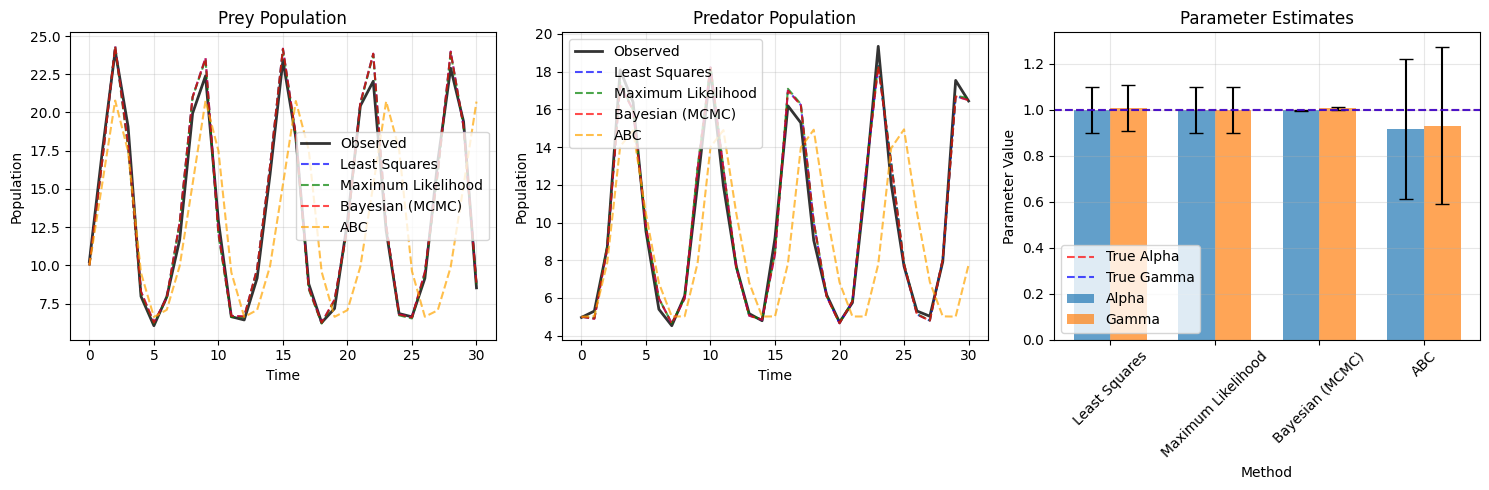

In [15]:
print("📋 COMPREHENSIVE COMPARISON")
print("=" * 50)

# Compile all results
all_results = {
    'observed': obs_data,
    'ls': ls_result,
    'mle': mle_result,
    'mcmc': mcmc_result,
    'abc': abc_result
}

# Create comparison table
comparison_df = create_comparison_table(all_results, obs_data['true_params'])

print("SUMMARY TABLE:")
print(comparison_df.to_string(index=False))
print()

# Display formatted summary
display_results_summary(all_results)

# Create comprehensive plots
plot_comparison_results(all_results, obs_data['true_params'])

## Dashboard to compare parameter estimation methods

In [24]:
# Interactive Dashboard with Manual Control
def run_estimation_manual():
    """Manual execution function triggered by button click"""
    # Get current values from all widgets
    true_alpha = data_controls[0].value
    true_gamma = data_controls[1].value
    noise_level = data_controls[2].value
    time_points = data_controls[3].value
    enable_ls = method_controls[0].value
    enable_mle = method_controls[1].value
    enable_mcmc = method_controls[2].value
    enable_abc = method_controls[3].value
    mcmc_samples = mcmc_controls[0].value
    mcmc_burnin = mcmc_controls[1].value
    mcmc_proposal_std = mcmc_controls[2].value
    mcmc_init_alpha = mcmc_controls[3].value
    mcmc_init_gamma = mcmc_controls[4].value
    abc_samples = abc_controls[0].value
    abc_tolerance = abc_controls[1].value

    # Get starting points for LS and MLE
    ls_starting_points = get_starting_points_from_widgets(ls_starting_controls)
    mle_starting_points = get_starting_points_from_widgets(mle_starting_controls)

    with output:
        clear_output(wait=True)
        print("🚀 Running parameter estimation...")

        # Generate data
        obs_data = generate_observed_data(true_alpha, true_gamma, noise_level, time_points)
        results = {'observed': obs_data}

        # Run selected methods
        if enable_ls:
            print("Running Least Squares...")
            results['ls'] = estimate_least_squares(obs_data['data'], obs_data['time'], obs_data['initial'],
                                                 starting_points=ls_starting_points)

        if enable_mle:
            print("Running MLE...")
            results['mle'] = estimate_mle(obs_data['data'], obs_data['time'], obs_data['initial'],
                                        starting_points=mle_starting_points)

        if enable_mcmc:
            print("Running MCMC...")
            results['mcmc'] = metropolis_hastings(
                obs_data['data'], obs_data['time'], obs_data['initial'],
                n_samples=mcmc_samples, burn_in=mcmc_burnin,
                proposal_std=mcmc_proposal_std,
                current_params=(mcmc_init_alpha, mcmc_init_gamma)
            )

        if enable_abc:
            print("Running ABC...")
            results['abc'] = estimate_abc(
                obs_data['data'], obs_data['time'], obs_data['initial'],
                n_samples=abc_samples, tolerance=abc_tolerance if abc_tolerance > 0 else None
            )

        # Create plots and table
        print("Creating visualizations...")
        plot_comparison_results(results, obs_data['true_params'])

        print("\n📊 Results Summary:")
        table = create_comparison_table(results, obs_data['true_params'])
        print(table.to_string(index=False))

        print(f"\n🎯 True parameters: Alpha = {true_alpha:.3f}, Gamma = {true_gamma:.3f}")

def get_starting_points_from_widgets(starting_controls):
    """Extract starting points from widget controls"""
    starting_points = []
    for i in range(0, len(starting_controls), 2):
        alpha = starting_controls[i].value
        gamma = starting_controls[i+1].value
        starting_points.append((alpha, gamma))
    return starting_points

def create_starting_point_widgets(method_name, default_points=[(0.5, 0.5), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0)]):
    """Create widgets for controlling starting points"""
    widgets_list = []
    for i, (alpha, gamma) in enumerate(default_points):
        alpha_widget = widgets.FloatSlider(
            value=alpha, min=0.1, max=3.0, step=0.1,
            description=f'{method_name} Start {i+1} α:',
            style={'description_width': '120px'}
        )
        gamma_widget = widgets.FloatSlider(
            value=gamma, min=0.1, max=3.0, step=0.1,
            description=f'{method_name} Start {i+1} γ:',
            style={'description_width': '120px'}
        )
        widgets_list.extend([alpha_widget, gamma_widget])
    return widgets_list

In [26]:
# Create interactive widgets
style = {'description_width': 'initial'}

# Data generation controls
data_controls = [
    widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='True Alpha:', style=style),
    widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='True Gamma:', style=style),
    widgets.FloatSlider(value=0.05, min=0.01, max=0.2, step=0.01, description='Noise Level:', style=style),
    widgets.IntSlider(value=31, min=15, max=60, step=1, description='Time Points:', style=style)
]

# Method selection
method_controls = [
    widgets.Checkbox(value=True, description='Least Squares'),
    widgets.Checkbox(value=True, description='Maximum Likelihood'),
    widgets.Checkbox(value=True, description='Bayesian MCMC'),
    widgets.Checkbox(value=True, description='ABC Estimation')
]

# MCMC controls
mcmc_controls = [
    widgets.IntSlider(value=2000, min=500, max=5000, step=250, description='MCMC Samples:', style=style),
    widgets.IntSlider(value=500, min=100, max=1000, step=50, description='MCMC Burn-in:', style=style),
    widgets.FloatSlider(value=0.05, min=0.01, max=0.2, step=0.01, description='MCMC Proposal Std:', style=style),
    widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='MCMC Init Alpha:', style=style),
    widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='MCMC Init Gamma:', style=style)
]

# ABC controls
abc_controls = [
    widgets.IntSlider(value=1000, min=250, max=2500, step=250, description='ABC Samples:', style=style),
    widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='ABC Tolerance (0=auto):', style=style)
]

# Starting points controls for LS and MLE
ls_starting_controls = create_starting_point_widgets('LS')
mle_starting_controls = create_starting_point_widgets('MLE')

# Create the Start Run button
start_button = widgets.Button(
    description='🚀 Start Run',
    disabled=False,
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to run parameter estimation',
    icon='play'
)

# Connect button to the function
start_button.on_click(lambda x: run_estimation_manual())

# Create output widget
output = widgets.Output()

# Organize widgets in sections
data_section = widgets.VBox([
    widgets.HTML("<h3>📊 Data Generation Parameters</h3>"),
    *data_controls
])

methods_section = widgets.VBox([
    widgets.HTML("<h3>🔧 Estimation Methods</h3>"),
    *method_controls
])

mcmc_section = widgets.VBox([
    widgets.HTML("<h3>⛓️ MCMC Settings</h3>"),
    *mcmc_controls
])

abc_section = widgets.VBox([
    widgets.HTML("<h3>🎲 ABC Settings</h3>"),
    *abc_controls
])

# Starting points sections
ls_starting_section = widgets.VBox([
    widgets.HTML("<h3>🎯 Least Squares Starting Points</h3>"),
    widgets.HBox([ls_starting_controls[0], ls_starting_controls[1]]),  # Start 1
])

mle_starting_section = widgets.VBox([
    widgets.HTML("<h3>🎯 MLE Starting Points</h3>"),
    widgets.HBox([mle_starting_controls[0], mle_starting_controls[1]]),  # Start 1
])

# Create layout with sections - now in 3 columns
controls_layout = widgets.HBox([
    widgets.VBox([data_section, methods_section]),
    widgets.VBox([mcmc_section, abc_section]),
    widgets.VBox([ls_starting_section, mle_starting_section])
])

# Main dashboard layout
dashboard = widgets.VBox([
    widgets.HTML("<h2>🔬 Lotka-Volterra Parameter Estimation Dashboard</h2>"),
    widgets.HTML("<hr>"),
    controls_layout,
    widgets.HTML("<br>"),
    start_button,
    widgets.HTML("<br>"),
    output
])

# Display the dashboard
print("🔬 Lotka-Volterra Parameter Estimation Dashboard")
print("=" * 60)
print("📝 Adjust parameters above and click 'Start Run' to execute estimation")
display(dashboard)

🔬 Lotka-Volterra Parameter Estimation Dashboard
📝 Adjust parameters above and click 'Start Run' to execute estimation
